# Baseline Model for Mask Classification Model

**About**:
Train a simple baseline to classify a mask-wearing image 
into one of three classes: "n95", "surgical" or "other".

## The Dataset

In [ ]:
%%shell
jupyter nbconvert --to html Baseline_MaskType.ipynb

[NbConvertApp] Converting notebook Lab_2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 948618 bytes to Lab_2_Cats_vs_Dogs.html


Import libraries and modules.

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt # for visualization
import matplotlib.ticker as ticker


Raw images were obtained from the following sources:

* **SSDMNV2 2020 Model Data (withmask folder)** https://github.com/TheSSJ2612/Real-Time-Medical-Mask-Detection/releases/ 
* *There were very few n95 images, so shutterstock was used to obtain some more n95 data.* **Shutterstock** https://www.shutterstock.com/search/n95+mask

The raw data went through cleaning and augmentation. Then they were manually categorized into the types "n95 (and similar)", "surgical", and "other".

In the training and testing process of the baseline model, a total of 600 n95 mask images (70% real, 30% artificial), 1600 surgical mask images (real), and 600 other type masks (real) were used in training and testing the baseline model. These images were shuffled randomly using an internally written script and then split into training, validation, and testing datasets at a 60-20-20 ratio.

In [2]:
#mount googledrive where data is stored
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
data600_path = '/content/gdrive/My Drive/APS360/MaskType/Data600/'

data_path = data600_path


In [26]:
img_size = 224
# color image transform, tensors must be the same size even though images themselves may not be
color_transform = transforms.Compose([transforms.Resize((img_size,img_size)), 
                                transforms.ToTensor()])

# greyscale image transform, tensors must be the same size even though images themselves may not be
greyscale_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.Resize((img_size,img_size)), 
                                transforms.ToTensor()])

# use 60 - 20 - 20 split between training, validation, and testing
train_data = torchvision.datasets.ImageFolder(data_path + 'train', transform=color_transform)
val_data = torchvision.datasets.ImageFolder(data_path + 'val', transform=color_transform)
test_data = torchvision.datasets.ImageFolder(data_path + 'test', transform=color_transform)

# greyscale data
grey_train_data = torchvision.datasets.ImageFolder(data_path + 'train', transform=greyscale_transform)
grey_val_data = torchvision.datasets.ImageFolder(data_path + 'val', transform=greyscale_transform)
grey_test_data = torchvision.datasets.ImageFolder(data_path + 'test', transform=greyscale_transform)

classes = ('n95', 'other', 'surgical')

## Visualization
A set of helper functions to visualize data and results to facilitate comprehension and analysis.

In [5]:
def show_gt(labeled_data):
  # Display first 10 images with ground truth labels

  # one batch of images
  images, labels = iter(labeled_data).next()
  images = images.numpy()

  # plot the images and their corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(10):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])


In [6]:
def plot_perf(epochs, losses, train_acc, val_acc):
  # Plots 2 graphs: 
  # one graph of training loss,
  # one graph of training and validation accuracy
  plt.title("Losses Training Curve")
  plt.plot(epochs, losses, label="Train")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accuracy Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, val_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

def plot_overlay_perf(model_name, epochs, losses, train_acc, val_acc):
  # Plots 1 graph: 
  # bar chart of training loss 
  # with training and validation accuracy line charts overlayed on top
  fig = plt.figure()

  # a large graph
  fig.set_size_inches(11, 8.5)
  ax = fig.gca()
  ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

  # overlay losses with training and validation accuracy
  ax.bar(epochs, losses, color=(0.9, 0.9, 0.6, 0.5), label="Training loss")
  ax.plot(epochs, train_acc, color='blue', label="Training accuracy")
  ax.plot(epochs, val_acc, color=(1, 0.4, 0, 1), label="Validation accuracy")

  # graph features
  ax.set_xlim(epochs[0] - 0.5, epochs[len(epochs) - 1] + 0.5)
  plt.title(model_name + " Performance", weight = 'bold')
  plt.xlabel("Epoch", weight = 'bold')
  plt.ylabel("%", weight = 'bold')
  ax.legend(loc="lower center")

  plt.show()

The original dataset was converted into 3-channel greyscale prior to being used in training the model.

(Top) A sample of the original color data
-----------------------------------
(Bottom) The greyscale version used in training


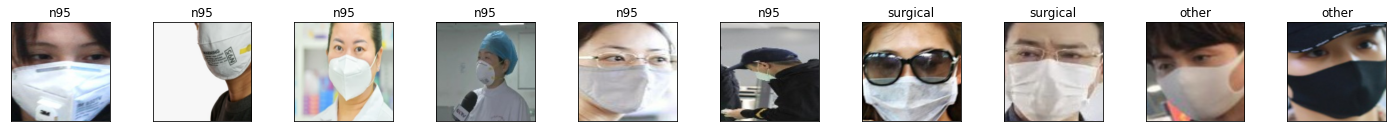

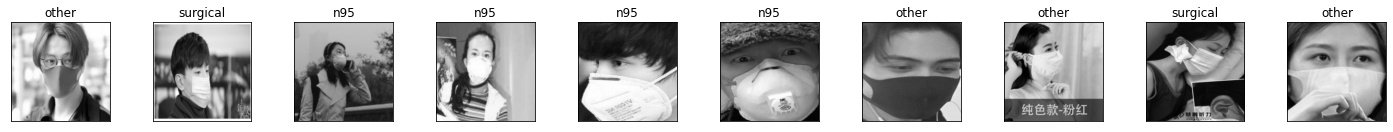

In [ ]:
batch_size = 20
num_workers = 1

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

print("(Top) A sample of the original color data")
show_gt(train_loader)
print("-----------------------------------")
print("(Bottom) The greyscale version used in training")
train_loader_ = torch.utils.data.DataLoader(grey_train_data, batch_size=batch_size, shuffle=True)
show_gt(train_loader_)

##Building the Model

In [7]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

In [13]:
def train(model, training, validation, batch_size=100, num_epochs=20, learn_rate=0.001):
    torch.manual_seed(10)

    # classification with multiple classes
    criterion = nn.CrossEntropyLoss()

    # use Adam's optimizer
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    train_loader_ = torch.utils.data.DataLoader(training, batch_size=batch_size, shuffle=True)

    val_loader_ = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=True)

    losses, train_acc, val_acc = [], [], []
    epochs = []

    print ("Training Started...")
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader_):

            out = model(imgs)             
            loss = criterion(out, labels) 
            loss.backward()              
            optimizer.step()              
            optimizer.zero_grad()
        
        # track loss
        losses.append(float(loss))          
        
        # track accuracy
        train_acc.append(get_accuracy(model, train_loader_))
        val_acc.append(get_accuracy(model, val_loader_))
        epochs.append(epoch+1)

        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (epoch+1, loss, train_acc[-1], val_acc[-1]))
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)

    return epochs, losses, train_acc, val_acc

## Measuring Performance

In [8]:
def get_accuracy(model, data_loader):
    # Calculate accuracy = # correct predictions / # total predictions
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [10]:
from torchvision.transforms import functional as tf
def get_precision_recall(model, labeled_data):
    true_pos = 0
    false_pos = 0
    false_neg = 0

    all_wrong_predictions = []
    answers_wrong_predictions = []

    # for images, labels, in labeled_

    n95_true_pos = 0
    n95_false_pos = 0
    n95_false_neg = 0
    
    other_true_pos = 0
    other_false_pos = 0
    other_false_neg = 0

    surgical_true_pos = 0
    surgical_false_pos = 0
    surgical_false_neg = 0 

    for imgs, labels in labeled_data:
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]

        # true positive
        right_idx = (pred == labels.view_as(pred)).nonzero()[:, 0]
        true_pos += pred.eq(labels.view_as(pred)).sum().item()
        right_preds = labels.view_as(pred)[right_idx]

        for right_pred in right_preds:
          if right_pred == 0:
            n95_true_pos += 1
          elif right_pred == 1:
            other_true_pos += 1
          elif right_pred == 2:
            surgical_true_pos += 1

        # false
        wrong_idx = (pred != labels.view_as(pred)).nonzero()[:, 0]
        wrong_samples = imgs[wrong_idx]
        wrong_preds = pred[wrong_idx]
        # correct answer for false predictions
        actual_preds = labels.view_as(pred)[wrong_idx]

        for wrong_pred in wrong_preds:
          if wrong_pred == 0:
            n95_false_pos += 1
          elif wrong_pred == 1:
            other_false_pos += 1
          elif wrong_pred == 2:
            surgical_false_pos += 1
        
        for actual_pred in actual_preds:
          if actual_pred == 0:
            n95_false_neg += 1
          elif actual_pred == 1:
            other_false_neg += 1
          elif actual_pred == 2:
            surgical_false_neg += 1
        
        # save wrong predictions for failure case analysis
        for i in range(len(wrong_samples) - 1):
          sample = wrong_samples[i]
          sample = sample * 224
          sample = sample.byte()
          img = tf.to_pil_image(sample)
          save_path = '/content/gdrive/My Drive/APS360/MaskType/Baseline/Wrong/'

          img.save(save_path + 'wrong_idx{}_pred{}_actual{}.png'.format(
              wrong_idx[i], wrong_pred.item(), actual_pred.item()))

    n95_precision_recall = [n95_true_pos / float( n95_true_pos + n95_false_pos),
                        n95_true_pos / float( n95_true_pos + n95_false_neg)]
    other_precision_recall = [other_true_pos / float( other_true_pos + other_false_pos),
                        other_true_pos / float( other_true_pos + other_false_neg)] 
    surgical_precision_recall = [surgical_true_pos / float( surgical_true_pos + surgical_false_pos),
                        surgical_true_pos / float( surgical_true_pos + surgical_false_neg)]

    # print out false pos, false neg, true pos stats
    print("\n\tn95")
    print("\t\ttrue positives = ", n95_true_pos, ", false positives = ", n95_false_pos, ", false negatives = ", n95_false_neg)
    print("\n\tother")
    print("\t\ttrue positives = ", other_true_pos, ", false positives = ", other_false_pos, ", false negatives = ", other_false_neg)
    print("\n\tsurgical")
    print("\t\ttrue positives = ", surgical_true_pos, ", false positives = ", surgical_false_pos, ", false negatives = ", surgical_false_neg)
    return [n95_precision_recall, other_precision_recall, surgical_precision_recall]

## A Simple CNN Baseline Model
My initial hypothesis was that a simple CNN with 3 convolution layers, 2 fully connected layers, and 3 max pooling layers, along with a small kernal would have the capacity to classify the images. After several rounds of tuning, the best training and validation accuracy hovered at 50%. I decided to increase the model capacity by increasing the number of convolution layers.

After increasing the number of convlution layers, the model performance improved a lot. The best training accuracy was > 80% and the model loss decreased. However, after several attempts to tune the layer and kernel sizes, the batch size, number of epochs, and the learning rate, the validation accuracy failed to improve past 50% (note that an accuracy of ~33% would be equivalent to a random model performance since the masks are being classified into 3 categories). 

Techniques such as dropout and L2 regularization were also tried, in attempt to decrease the overfit on training data, but did not have any significant impacts.

Below shows the CNN model with additional layers added and its performance.

In [ ]:
torch.manual_seed(10) # set the random seed
from math import floor

class CNNClassifier_bw(nn.Module):
    def __init__(self, kernel_sizes = [2, 2, 2], name = "CNN_Classifier"):
        super(CNNClassifier_bw, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_sizes[0])
        self.conv2 = nn.Conv2d(5, 3, kernel_sizes[1])
        self.conv3 = nn.Conv2d(3, 3, kernel_sizes[2])
        self.conv4 = nn.Conv2d(3, 3, kernel_sizes[2])
        self.conv5 = nn.Conv2d(3, 3, kernel_sizes[2])
        self.conv6 = nn.Conv2d(5, 3, kernel_sizes[2])
        self.conv7 = nn.Conv2d(3, 3, kernel_sizes[2])
        self.conv8 = nn.Conv2d(3, 3, kernel_sizes[2])
        self.conv9 = nn.Conv2d(3, 3, kernel_sizes[2])
        self.conv10 = nn.Conv2d(3, 3, kernel_sizes[2])

        self.maxpool = nn.MaxPool2d(2, 2)

        # Computing the correct input size into the Fully Connected Layer
        self.x = floor((224 - kernel_sizes[0] + 1)/2)
        self.y = floor((self.x - kernel_sizes[1] + 1)/2)
        self.z = floor((self.y - kernel_sizes[2] + 1)/2)
        self.FC_input = 3*self.z*self.z

        self.fc1 = nn.Linear(self.FC_input, 32)
        self.fc2 = nn.Linear(32, 9)

        self.name = name

        # try with dropout 
        # self.dropout = nn.Dropout(0.25)  

    def forward(self, img):
        x = self.maxpool(F.relu(self.conv1(img)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv10(x)))

        x = x.view(-1, self.FC_input)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


Training Started...
Epoch 1; Loss 0.978206; Train Acc 0.431481; Val Acc 0.447222
Epoch 2; Loss 1.043792; Train Acc 0.502778; Val Acc 0.480556
Epoch 3; Loss 0.764240; Train Acc 0.536111; Val Acc 0.516667
Epoch 4; Loss 1.025031; Train Acc 0.523148; Val Acc 0.491667
Epoch 5; Loss 0.886064; Train Acc 0.578704; Val Acc 0.494444
Epoch 6; Loss 0.827558; Train Acc 0.569444; Val Acc 0.519444
Epoch 7; Loss 0.804479; Train Acc 0.606481; Val Acc 0.511111
Epoch 8; Loss 0.857714; Train Acc 0.624074; Val Acc 0.536111
Epoch 9; Loss 1.020184; Train Acc 0.616667; Val Acc 0.491667
Epoch 10; Loss 0.656394; Train Acc 0.660185; Val Acc 0.508333
Epoch 11; Loss 0.610997; Train Acc 0.729630; Val Acc 0.480556
Epoch 12; Loss 0.586995; Train Acc 0.733333; Val Acc 0.505556
Epoch 13; Loss 0.846663; Train Acc 0.800000; Val Acc 0.488889
Epoch 14; Loss 0.439342; Train Acc 0.824074; Val Acc 0.502778
Epoch 15; Loss 0.790412; Train Acc 0.841667; Val Acc 0.477778
Epoch 16; Loss 0.278037; Train Acc 0.902778; Val Acc 0.5222

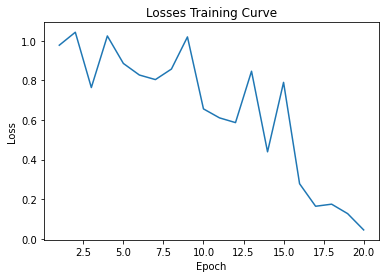

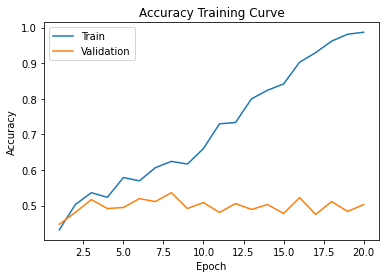

In [ ]:
baseline1 = CNNClassifier_bw()
simple_epochs, simple_losses, simple_train_acc, simple_val_acc = train(baseline1, grey_train_data, grey_val_data, batch_size=20, num_epochs=20, learn_rate=0.01)
plot_perf(simple_epochs, simple_losses, simple_train_acc, simple_val_acc)

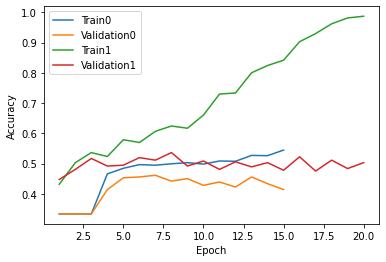

In [ ]:
# comparing the simple CNN model (0) and the CNN model with additional layers (1)
plt.plot(baseline0_epochs, baseline0_train_acc, label="Train0")
plt.plot(baseline0_epochs, baseline0_val_acc, label="Validation0")
plt.plot(epochs, simple_train_acc, label="Train1")
plt.plot(epochs, simple_val_acc, label="Validation1")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

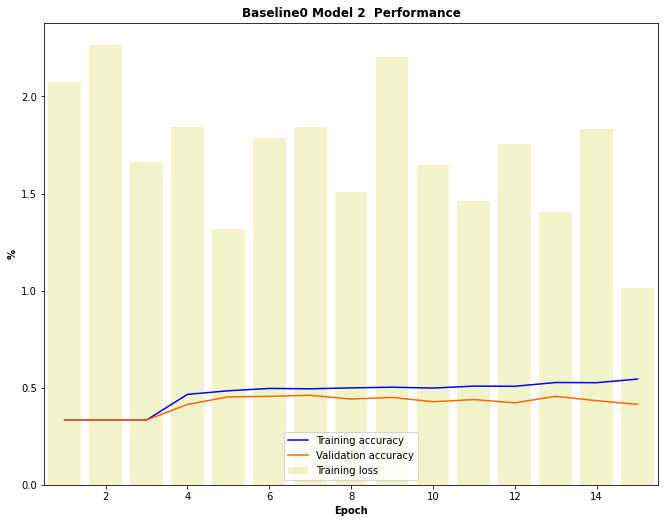

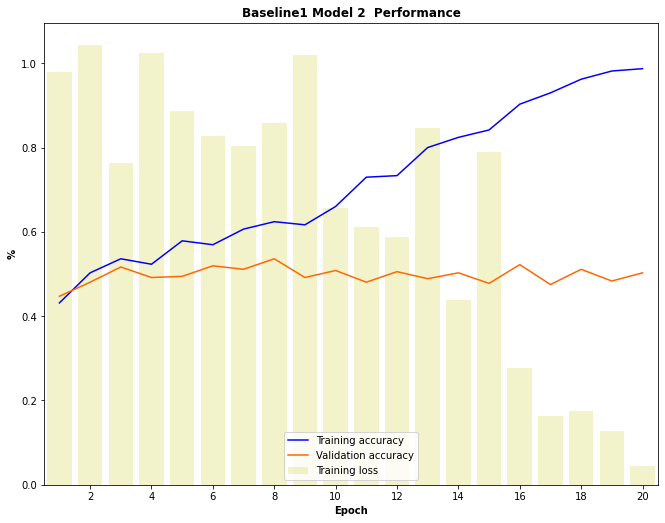

In [ ]:
plot_overlay_perf("Baseline0 Model 2 ", baseline0_epochs, baseline0_losses, baseline0_train_acc, baseline0_val_acc)
plot_overlay_perf("Baseline1 Model 2 ", simple_epochs, simple_losses, simple_train_acc, simple_val_acc)

As expected, the test accuracy of the improved CNN model was still poor. 

In [ ]:
test_loader_ = torch.utils.data.DataLoader(grey_test_data, batch_size=batch_size, shuffle=True)
print("Test accuracy was ", get_accuracy(baseline1, test_loader_))

Test accuracy was  0.46111111111111114


In [ ]:
print(get_precision_recall(baseline1, test_loader_))

[[0.5142857142857142, 0.45], [0.5047619047619047, 0.44166666666666665], [0.3933333333333333, 0.49166666666666664]]


From analyzing the precision and recall for each mask type, and looking at the test images that were classified wrong, I concluded that the poor accuracy was likely due to the model having a hard time learning weights that will help it locate the person's face. This would heavily impact its ability to identify the mask, since the mask is on the person's face. 

The high training accuracy could simply be from the model learning weights that had to do with irrelevant features. It could very well be distracted by information about the person's clothing, the background, etc. These features are irrelevant to the type of mask, therefore when it operated on the validation and test datasets, it failed to generalize and ended up being heavily overfitted on the training dataset.

Therefore, I concluded that building a simple transfer learning model using AlexNet would make a better baseline model, ie. less overfit on the training dataset, than the improved CNN.

## The ALEXNET Baseline Model

After tuning hyperparameters, the final ALEXNET baseline model has a 69.5% testing accuracy.

L2 regularization was used in the final baseline model because of its smoother validation accuracy performance. 

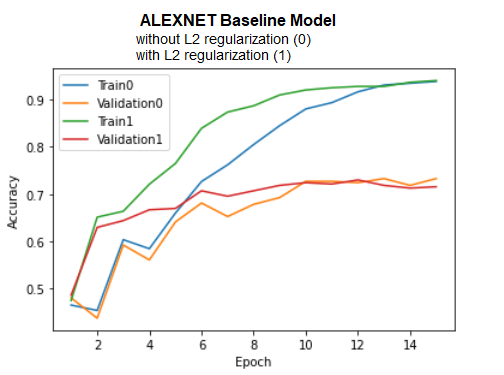

In [ ]:
# download pre-trained weights from alexnet
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

In [ ]:
import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
save_path = '/content/gdrive/My Drive/APS360/MaskType/Data600/Baseline/Features'

# load data for alex net
batch_size = 32
alexnet_train_loader = torch.utils.data.DataLoader(grey_train_data, batch_size=batch_size, shuffle=True)
alexnet_val_loader = torch.utils.data.DataLoader(grey_val_data, batch_size=batch_size, shuffle=True)
alexnet_test_loader = torch.utils.data.DataLoader(grey_test_data, batch_size=batch_size, shuffle=True)

n = 0
for imgs, labels in alexnet_train_loader:
  features = alexnet.features(imgs)
  features_tensor = torch.from_numpy(features.detach().numpy())
  for i in range(len(imgs) - 1):    
    folder_name = save_path + '/train/' + str(classes[labels[i]])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor[i].squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

n = 0
for imgs, labels in alexnet_val_loader:
  features = alexnet.features(imgs)
  features_tensor = torch.from_numpy(features.detach().numpy())
  for i in range(len(imgs) - 1):    
    folder_name = save_path + '/val/' + str(classes[labels[i]])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor[i].squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

n = 0
for imgs, labels in alexnet_test_loader:
  features = alexnet.features(imgs)
  features_tensor = torch.from_numpy(features.detach().numpy())
  for i in range(len(imgs) - 1):    
    folder_name = save_path + '/test/' + str(classes[labels[i]])
    if not os.path.isdir(folder_name):
      print("made directory")
      os.mkdir(folder_name)
    torch.save(features_tensor[i].squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
# load alexnet features
batch_size = 32
train_features = torchvision.datasets.DatasetFolder(save_path + '/train', loader=torch.load,
extensions=('.tensor'))
val_features = torchvision.datasets.DatasetFolder(save_path + '/val', loader=torch.load,
extensions=('.tensor'))
test_features = torchvision.datasets.DatasetFolder(save_path + '/test', loader=torch.load,
extensions=('.tensor'))

num_workers = 1
train_features_loader = torch.utils.data.DataLoader(train_features, batch_size=batch_size,
 num_workers=num_workers, shuffle=True)
val_features_loader = torch.utils.data.DataLoader(val_features, batch_size=batch_size,
 num_workers=num_workers, shuffle=True)
test_features_loader = torch.utils.data.DataLoader(test_features, batch_size=batch_size,
 num_workers=num_workers, shuffle=True)

torch.manual_seed(10) # set the random seed
from math import floor

class AlexNetClassifier(nn.Module):
  def __init__(self, name = "AlexNet_Classifier"):
    super(AlexNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(256, 512, 3)

    self.pool = nn.MaxPool2d(2, 2)

    # Computing the correct input size into the Fully Connected Layer
    self.x = floor((6 - 3 + 1)/2)

    self.FC_input = 512*self.x*self.x
    self.fc1 = nn.Linear(self.FC_input, 32)
    self.fc2 = nn.Linear(32, 9)

    self.name = name 

  def forward(self, features):
    x = self.pool(F.relu(self.conv1(features)))
    x = x.view(-1, self.FC_input)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    # use softmax
    x = F.softmax(x, dim=1)

    return x

In [ ]:
def train_alexnet(model, training, validation, batch_size=100, num_epochs=20, learn_rate=0.001):
    torch.manual_seed(10)

    # classification with multiple classes
    criterion = nn.CrossEntropyLoss()

    # use Adam's optimizer with L2 regularization
    optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-5)

    train_loader_ = torch.utils.data.DataLoader(training, batch_size=batch_size, shuffle=True)

    val_loader_ = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=True)

    losses, train_acc, val_acc = [], [], []
    epochs = []

    print ("Training Started...")
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader_):

            out = model(imgs)             
            loss = criterion(out, labels) 
            loss.backward()              
            optimizer.step()              
            optimizer.zero_grad()
        
        # track loss
        losses.append(float(loss))          
        
        # track accuracy
        train_acc.append(get_accuracy(model, train_loader_))
        val_acc.append(get_accuracy(model, val_loader_))
        epochs.append(epoch+1)

        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (epoch+1, loss, train_acc[-1], val_acc[-1]))
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)

    return epochs, losses, train_acc, val_acc

In [ ]:
final_baseline = AlexNetClassifier()

final_baseline_epochs, final_baseline_losses, final_baseline_train_acc, final_baseline_val_acc = train_alexnet(final_baseline,  train_features, val_features, num_epochs=15)
plot_perf(final_baseline_epochs, final_baseline_losses, final_baseline_train_acc, final_baseline_val_acc)

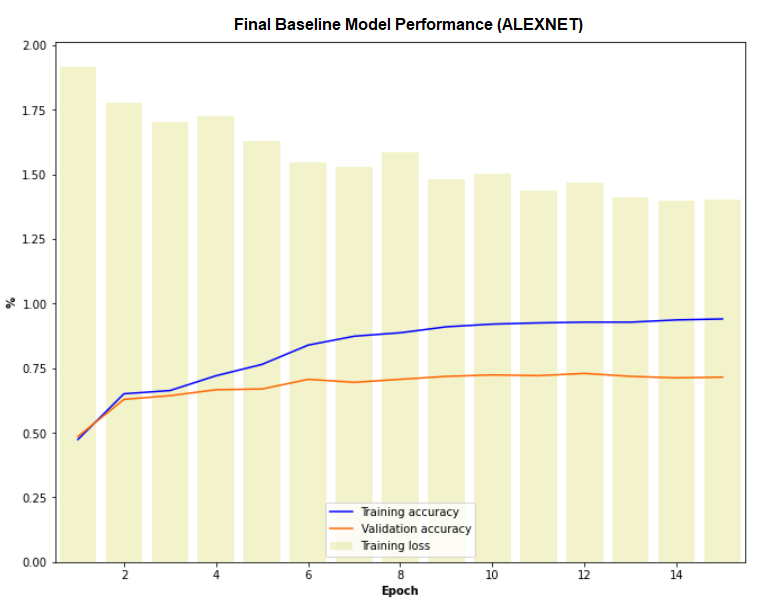

As seen above, one of the biggest flaws of this baseline model is the high training loss despite its relatively good training accuracy (>75%) and validation accuracy (~70%).

A goal for the team's model is to have a better loss-to-accuracy performance than the baseline.

### Testing the ALEXNET Baseline Model

In [ ]:
print("-----------------------------------------------------------")
print("TESTING FINAL BASELINE MODEL...")
print("Test accuracy was ", get_accuracy(final_baseline, test_features_loader))